In [2]:
import numpy as np
import scipy.sparse as sp

Auxiliary functions for the Immersed boundary method: delta's and interpolation 1D

In [54]:
def delta (r, dr):
    d = np.zeros_like(r)
    absr = np.abs(r/dr)
    m3 = absr>1.5
    m1 = absr<=0.5
    d[m1] = (1+np.sqrt(1-3*absr[m1]**2))/(3*dr)
    m2 = np.logical_not(np.logical_or(m1, m3))
    d[m2] = (5-3*absr[m2] - np.sqrt(1-3*(1-absr[m2])**2))/(6*dr)
    return d

In [53]:
def interpolation_1d(xi, x, dx, normalized=None, nelem=2):
    xi_x = np.argmin(np.abs(xi[:,np.newaxis]-x[np.newaxis,:]), axis=1) 
    xi_dx = dx[xi_x]
    
    scale_factor = xi_dx if normalized else np.ones_like(xi_dx)
        
    e_i, e_j, e_val=[], [], []
    for j in range(len(xi)):
        xj = xi_x[j]

        e_i.append(j*np.ones(2*nelem+1))
        e_j.append(np.arange(xj-nelem,xj+nelem+1))
        deltaj = delta((xi[j] - x[xj-nelem:xj+nelem+1]), xi_dx[j])
        e_val.append(scale_factor[j]*deltaj)
        
    e_i, e_j, e_val = np.asarray(e_i).ravel(), np.asarray(e_j).ravel(), np.asarray(e_val).ravel()
    E_ = sp.coo_matrix((e_val, (e_i, e_j)), shape=(len(xi), len(x)))
    return E_

Interpolation operator

In [49]:
def interpolation_hat(xi, eta, ds, x, y, xp, yp, dx, dy, dxp, dyp):
    yu, xu = yp, x[1:-1]
    Eux = interpolation_1d(xi, xu, dx, normalized=True)
    Euy = interpolation_1d(eta, yu, dyp, normalized=True)
    Euyy = sp.kron(Euy, np.ones_like(xu)).tocsr()
    Euxx = sp.kron(np.ones_like(yu), Eux).tocsr()
    Eu = Euyy.multiply(Euxx)

    yv, xv = y[1:-1], xp
    Evx = interpolation_1d(xi, xv, dxp, normalized=True)
    Evy = interpolation_1d(eta, yv, dy, normalized=True)
    Evyy = sp.kron(Evy, np.ones_like(xv)).tocsr()
    Evxx = sp.kron(np.ones_like(yv), Evx).tocsr()
    Ev = Evyy.multiply(Evxx)
    
    E = sp.block_diag([Eu, Ev])

    return E

Regularization operator

In [50]:
def regularization_hat(xi, eta, ds, x, y, xp, yp, dx, dy, dxp, dyp):
    yu, xu = yp, x[1:-1]
    Eux = interpolation_1d(xi, xu, dx, normalized=False)
    Euy = interpolation_1d(eta, yu, dyp, normalized=False)
    Euyy = sp.kron(Euy, np.ones_like(xu)).tocsr()
    Euxx = sp.kron(np.ones_like(yu), Eux).tocsr()
    Eu = Euyy.multiply(Euxx)

    yv, xv = y[1:-1], xp
    Evx = interpolation_1d(xi, xv, dxp, normalized=False)
    Evy = interpolation_1d(eta, yv, dy, normalized=False)
    Evyy = sp.kron(Evy, np.ones_like(xv)).tocsr()
    Evxx = sp.kron(np.ones_like(yv), Evx).tocsr()
    Ev = Evyy.multiply(Evxx)
    
    β = sp.block_diag([sp.diags(ds, 0), sp.diags(ds, 0)])
    
    Eoa = sp.block_diag([Eu, Ev])

    return Eoa.T.dot(β)

1.0


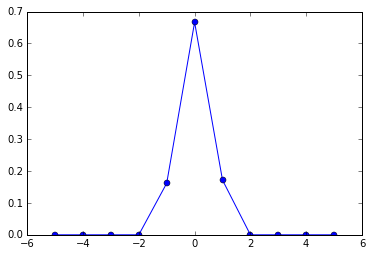

In [52]:
if __name__=="__main__":
    %matplotlib inline
    import matplotlib.pyplot as plt
    import mpld3
    mpld3.enable_notebook()
    x = np.linspace(-5, 5, 11);
    xi = np.asarray([0.01,]);
    d = delta (x-xi, 1)
    plt.plot(x, d, '-o')
    print(np.sum(d))